In [21]:
# Imports & Data Load
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
import json
import math
from itertools import product
import pickle

# Reusable utilities
from utiles import (
    prepare_features,
    fit_tree_for_clusters,
    evaluate_leaf_bad_rates,
    proportion_ci_wilson,
    compute_cluster_profiles,
    chi_square_test_cluster_target,
    pairwise_bad_rate_ztests,
    build_readable_rules,
 )

In [22]:
DATA_PATH = Path('/home/ali/repos/creadit_risk/customer_segmantation/outputs2/customer_segmantation_unbaked_dtree_v1_datasource/data/unbanked_customer_segmentation_final.csv')
assert DATA_PATH.exists(), f"Dataset file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)

# Basic schema validation based on documentation
expected_cols = {'customer_id','age','marital_status','income_delta_percentage','address_category','jobtitle_category','gender','target'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing expected columns: {missing}"

# Ensure target is binary 0/1
assert set(df['target'].unique()) <= {0,1}, 'Target must be binary 0/1'

overall_bad_rate = df['target'].mean()
print(f"Overall bad rate: {overall_bad_rate:.2%}")

df.head()

Loaded shape: (50091, 8)
Overall bad rate: 13.79%


,customer_id,age,marital_status,income_delta_percentage,address_category,jobtitle_category,gender,target
0,237305,57,Married,-18.367347,B,D,MALE,0
1,237305,57,Married,-18.367347,B,D,MALE,0
2,237318,42,Married,-62.962963,B,A,MALE,0
3,237324,25,Married,5.820106,D,A,MALE,0
4,237324,25,Married,5.820106,D,A,MALE,0


In [23]:
# Features & splits via utilities
from typing import Tuple, Dict

categorical_cols = ['marital_status','address_category','jobtitle_category','gender']
numeric_cols = ['age','income_delta_percentage']

# Prepare X, y, feature names, and fitted encoder
X, y, feature_names, enc = prepare_features(
    df, categorical_cols=categorical_cols, numeric_cols=numeric_cols, target_col='target'
 )

# Train/validation split (stratified to keep overall rate)
X_train, X_val, y_train, y_val, df_train_idx, df_val_idx = train_test_split(
    X, y, df.index, test_size=0.3, random_state=42, stratify=y
)

print('Prepared data dimensions:', X.shape)
print('feature_names:', feature_names)

Prepared data dimensions: (50091, 6)
feature_names: ['age', 'income_delta_percentage', 'marital_status', 'address_category', 'jobtitle_category', 'gender']


In [24]:
def _two_prop_pval(bad1: int, n1: int, bad2: int, n2: int) -> float:
    # Pooled two-proportion z-test, two-sided
    if n1 == 0 or n2 == 0:
        return 1.0
    p1, p2 = bad1 / n1, bad2 / n2
    p_pool = (bad1 + bad2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))
    if se == 0:
        # If both perfectly 0 or 1, treat as no evidence if equal else strong difference
        return 1.0 if p1 == p2 else 0.0
    z = (p1 - p2) / se
    return float(2 * (1 - stats.norm.cdf(abs(z))))


def _compute_bins(df: pd.DataFrame, score_col: str, target_col: str, edges: np.ndarray) -> pd.DataFrame:
    cats = pd.cut(df[score_col], bins=edges, right=False, include_lowest=True)
    agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
    out = agg.reset_index()
    out["left"] = out[score_col].apply(lambda iv: iv.left)
    out["right"] = out[score_col].apply(lambda iv: iv.right)
    out["rate"] = out["bad"] / out["n"].where(out["n"] > 0, np.nan)
    return out[["left", "right", "bad", "n", "rate"]]


def make_significant_pd_bands(
    df: pd.DataFrame,
    score_col: str = "pd_score",
    target_col: str = "target",
    *,
    init_bins: int = 20,
    max_bands: int = 8,
    min_bin_size: float = 0.05,  # fraction of total rows per band
    alpha: float = 0.05,
) -> np.ndarray:
    """
    Create PD score bands by iteratively merging adjacent bins until:
    - All adjacent bad-rate differences are statistically significant (two-proportion z-test, p < alpha),
    - Each band has at least `min_bin_size` fraction of the portfolio, and
    - The number of bands <= `max_bands`.

    Returns the bin edges array suitable for pd.cut(..., bins=edges, right=False).
    """
    s = df[score_col].astype(float).values
    n_total = len(df)
    if n_total == 0:
        return np.array([0.0, 1.0000001])

    # Initial edges via quantiles (equal-frequency), dropping duplicates
    n_unique = int(pd.Series(s).nunique(dropna=True))
    nb = max(1, min(init_bins, n_unique))
    qs = np.linspace(0, 1, nb + 1)
    edges = np.quantile(s, qs)
    edges = np.unique(edges)

    # Ensure at least a single interval and open-right top edge
    smin, smax = float(np.nanmin(s)), float(np.nanmax(s))
    if edges[0] > smin:
        edges[0] = smin
    if edges[-1] < smax:
        # bump top slightly for right-open binning
        eps = np.nextafter(smax, np.inf) - smax
        edges[-1] = smax + max(eps, 1e-12)

    # If degenerate, return a single band
    if len(edges) < 2:
        return np.array([smin, smax + 1e-12])

    min_n = max(1, int(np.ceil(min_bin_size * n_total)))

    # Iteratively merge
    while True:
        bins = _compute_bins(df, score_col, target_col, edges)
        # Drop any empty bins created by duplicate edges
        bins = bins[bins["n"] > 0].reset_index(drop=True)
        # Rebuild edges from non-empty bins to keep consistency
        if len(bins) >= 1:
            new_edges = [bins.loc[0, "left"]]
            for i in range(len(bins)):
                new_edges.append(bins.loc[i, "right"])
            edges = np.array(new_edges)
        B = len(edges) - 1
        if B <= 1:
            break

        changed = False

        # Enforce minimum bin size first
        small_idx = bins.index[bins["n"] < min_n].tolist()
        if small_idx:
            i = small_idx[0]
            # choose neighbor with closest bad rate
            if i == 0:
                k = 1  # merge boundary between bin 0 and 1 -> remove edges[1]
            elif i == B - 1:
                k = B - 1  # merge boundary between last-1 and last -> remove edges[B-1]
            else:
                dl = abs(bins.loc[i, "rate"] - bins.loc[i - 1, "rate"]) if bins.loc[i - 1, "n"] > 0 else np.inf
                dr = abs(bins.loc[i, "rate"] - bins.loc[i + 1, "rate"]) if bins.loc[i + 1, "n"] > 0 else np.inf
                k = i if dl <= dr else i + 1
            edges = np.delete(edges, k)
            changed = True
        else:
            # Compute adjacency p-values
            pvals = []
            for i in range(B - 1):
                pvals.append(
                    _two_prop_pval(
                        int(bins.loc[i, "bad"]), int(bins.loc[i, "n"]),
                        int(bins.loc[i + 1, "bad"]), int(bins.loc[i + 1, "n"]),
                    )
                )
            max_p = max(pvals) if pvals else 0.0
            idx_max = int(np.argmax(pvals)) if pvals else 0

            # Merge by significance or to reduce count to max_bands
            if (B > max_bands) or (max_p >= alpha):
                # remove boundary between idx_max and idx_max+1
                k = idx_max + 1
                edges = np.delete(edges, k)
                changed = True

        if not changed:
            break

    return edges

In [25]:
def manual_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """Manual hyperparameter tuning with different combinations"""
    
    best_auc = 0
    best_model = None
    best_params = {}
    
    # Test different parameter combinations
    param_combinations = [
        {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200},
        {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200},
        {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300},
        {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150},
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9},
    ]
    
    for i, params in enumerate(param_combinations):
        print(f"Testing parameter combination {i+1}/{len(param_combinations)}")
        
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            random_state=42,
            n_jobs=-1,
            **params
        )
        
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        print(f"Params: {params} -> AUC: {auc_score:.4f}")
        
        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model
            best_params = params
    
    print(f"\nBest AUC: {best_auc:.4f}")
    print(f"Best parameters: {best_params}")
    
    return best_model

best_model = manual_hyperparameter_tuning(X_train, y_train, X_val, y_val)

# 2. Evaluate on validation set
def evaluate_model(model, X_val, y_val):
    """Evaluate model performance on validation set"""
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Predict classes
    y_pred = model.predict(X_val)
    
    # Calculate AUC
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    # Additional metrics
    print(f"\n{'='*50}")
    print(f"Validation AUC Score: {auc_score:.4f}")
    print(f"{'='*50}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    
    return auc_score, y_pred_proba

# Evaluate the model
auc_score, val_predictions = evaluate_model(best_model, X_val, y_val)

# Feature importance
feature_importance = best_model.feature_importances_
# 2. See which features are most important (sorted)
sorted_indices = np.argsort(feature_importance)[::-1]  # Descending order
print("\nTop 5 most important features:")
for i, idx in enumerate(sorted_indices[:5]):
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")

# 3. Create a DataFrame for better visualization (if you have feature names)
if hasattr(df, 'columns'):  # If using pandas DataFrame
    feature_names = feature_names
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nFeature importance DataFrame:")
    print(importance_df.head())

Testing parameter combination 1/5


Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200} -> AUC: 0.6516
Testing parameter combination 2/5
Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200} -> AUC: 0.6760
Testing parameter combination 3/5
Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300} -> AUC: 0.6716
Testing parameter combination 4/5
Params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150} -> AUC: 0.6718
Testing parameter combination 5/5
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9} -> AUC: 0.6812

Best AUC: 0.6812
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}

Validation AUC Score: 0.6812

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     12956
           1       0.50      0.02      0.04      2072

    accuracy                           0.86     15028
   macro avg       0.68      0.51      0.48  

In [26]:
# Class weight to handle imbalance (bad_rate ~ 14%)
all_proba = best_model.predict_proba(X)[:, 1]

# Attach probabilities to df and define risk bands via data-driven edges
# Step 1: attach PD scores
df = df.copy()
df['pd_score'] = all_proba

# Step 2: compute significant bands (data-driven)
edges = make_significant_pd_bands(
    df,
    score_col='pd_score',
    target_col='target',
    init_bins=20,
    max_bands=7,
    min_bin_size=0.05,  # each band at least 5% of portfolio
    alpha=0.05,
)

# Step 3: assign band labels 1..K (1=best/lowest risk)
K = len(edges) - 1
cat = pd.cut(df['pd_score'], bins=edges, right=False, include_lowest=True)
# codes in [0..K-1], -1 for NaN
codes = cat.cat.codes.to_numpy()
missing = int((codes < 0).sum())
if missing:
    print(f"Warning: {missing} rows fell outside band edges; they will be imputed to nearest band.")
    # Impute: values < edges[0] -> 0, values >= edges[-1] -> K-1
    vals = df['pd_score'].to_numpy()
    codes = np.where(vals < edges[0], 0, codes)
    codes = np.where(vals >= edges[-1], K - 1, codes)
    codes = np.where(codes < 0, 0, codes)

df['risk_band'] = codes + 1
print(f"Formed {K} risk bands with edges: {np.round(edges, 4)}")

# Quick sanity check of distribution and bad rates by band
band_summary = df.groupby('risk_band').agg(
    size=('target', 'size'),
    bad=('target', 'sum'),
    bad_rate=('target', 'mean'),
    pd_min=('pd_score', 'min'),
    pd_max=('pd_score', 'max'),
).reset_index()
band_summary['pct_portfolio'] = band_summary['size'] / len(df)
band_summary

Formed 7 risk bands with edges: [0.0015 0.0401 0.0968 0.134  0.189  0.263  0.328  0.92  ]


/tmp/ipykernel_9874/2319268597.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
/tmp/ipykernel_9874/2319268597.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(cats)[target_col].agg(["sum", "count"]).rename(columns={"sum": "bad", "count": "n"})
/tmp/ipykernel_9874/2319268597.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

,risk_band,size,bad,bad_rate,pd_min,pd_max,pct_portfolio
0,1,7504,92,0.012260,0.001530,0.040085,0.149807
1,2,12527,573,0.045741,0.040106,0.096788,0.250085
2,3,7632,744,0.097484,0.096805,0.133995,0.152363
3,4,9836,1479,0.150366,0.134011,0.188997,0.196363
4,5,7575,1796,0.237096,0.189010,0.262967,0.151225
5,6,2508,838,0.334131,0.263016,0.327967,0.050069
6,7,2509,1384,0.551614,0.328168,0.919912,0.050089


Bands chi-square = 7061.96 (dof=6) p-value=0.000e+00


/tmp/ipykernel_9874/2258665761.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profiles_bands, x='cluster', y='bad_rate', order=order, palette='viridis')


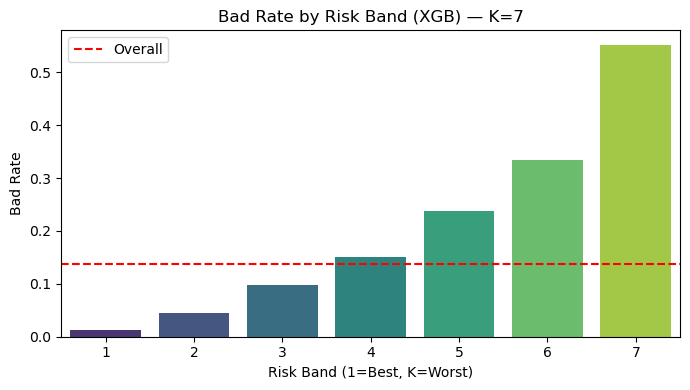

(   cluster   size  pct_portfolio  bad_rate    ci_low   ci_high  \
 0        1   7504       0.149807  0.012260  0.010008  0.015011   
 1        2  12527       0.250085  0.045741  0.042220  0.049541   
 2        3   7632       0.152363  0.097484  0.091031  0.104343   
 3        4   9836       0.196363  0.150366  0.143439  0.157566   
 4        5   7575       0.151225  0.237096  0.227653  0.246805   
 
    lift_vs_overall   age_mean  age_median  income_delta_percentage_mean  \
 0         0.088926  38.953092        39.0                    -29.579840   
 1         0.331773  41.043586        41.0                    -22.610879   
 2         0.707079  42.155136        42.0                    -23.347487   
 3         1.090643  42.017588        41.0                    -22.518360   
 4         1.719716  42.220330        41.0                    -20.013346   
 
    income_delta_percentage_median marital_status_mode  \
 0                      -38.914341             Married   
 1                    

In [27]:
# Use the same profiling utilities, treating risk_band like a cluster id
profiles_bands = compute_cluster_profiles(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target',
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
)

# Global test and pairwise tests across bands
chi2_b, p_chi_b, dof_b, expected_df_b = chi_square_test_cluster_target(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target'
)
print(f"Bands chi-square = {chi2_b:.2f} (dof={dof_b}) p-value={p_chi_b:.3e}")

pairwise_bands = pairwise_bad_rate_ztests(
    df.rename(columns={'risk_band':'cluster'}),
    cluster_col='cluster',
    target_col='target',
    adjust='bh'
)

# Visualize bad rate by band
plt.figure(figsize=(7,4))
order = profiles_bands.sort_values('cluster').cluster
sns.barplot(data=profiles_bands, x='cluster', y='bad_rate', order=order, palette='viridis')
plt.axhline(df['target'].mean(), color='red', linestyle='--', label='Overall')
plt.xlabel('Risk Band (1=Best, K=Worst)')
plt.ylabel('Bad Rate')
plt.title(f'Bad Rate by Risk Band (XGB) — K={int(df["risk_band"].nunique())}')
plt.legend()
plt.tight_layout()
fig_bands = plt.gcf()
plt.show()

profiles_bands.head(), pairwise_bands.head(28)

In [28]:
OUTPUT_DIR = Path('/home/ali/repos/creadit_risk/customer_segmantation/outputs2/customer_segmantation_unbaked_dtree_v1_datasource')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Save core tables
cols_bands = ['customer_id', 'risk_band', 'pd_score', 'target'] + numeric_cols + categorical_cols
df[cols_bands].to_csv(OUTPUT_DIR / 'customers_with_risk_bands.csv', index=False)
profiles_bands.to_csv(OUTPUT_DIR / 'band_profiles.csv', index=False)
pairwise_bands.to_csv(OUTPUT_DIR / 'band_pairwise_bad_rate_tests.csv', index=False)

# Save plot
fig_bands.savefig(OUTPUT_DIR / 'band_bad_rates.png', dpi=300)

# Save model and encoder
with open(OUTPUT_DIR / 'model_xgb.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open(OUTPUT_DIR / 'encoder_ordinal.pkl', 'wb') as f:
    pickle.dump(enc, f)

# Persist edges for reproducibility
np.savetxt(OUTPUT_DIR / 'band_edges.txt', edges, fmt='%.10f')

df.rename(columns={'risk_band':'cluster'}, inplace=True)

# Detailed per-cluster information (including numeric summaries and categorical distributions)
clusters_detailed = []
for c, grp in df.groupby('cluster'):
    size = int(len(grp))
    bad = int(grp['target'].sum())
    good = int((1 - grp['target']).sum())
    bad_rate = float(grp['target'].mean()) if size else float('nan')
    ci_low, ci_high = proportion_ci_wilson(bad, size)
    rec = {
        'cluster': int(c),
        'size': size,
        'pct_portfolio': float(size / len(df)) if len(df) else float('nan'),
        'bad': bad,
        'good': good,
        'bad_rate': bad_rate,
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
        'lift_vs_overall': float(bad_rate / overall_bad_rate) if overall_bad_rate else float('nan'),
        'numeric': {},
        'categorical': {},
    }
    for col in numeric_cols:
        rec['numeric'][col] = {
            'mean': float(grp[col].mean()),
            'median': float(grp[col].median()),
            'min': float(grp[col].min()),
            'p25': float(grp[col].quantile(0.25)),
            'p75': float(grp[col].quantile(0.75)),
            'max': float(grp[col].max()),
        }
    for col in categorical_cols:
        vc = grp[col].value_counts(dropna=False, normalize=True)
        rec['categorical'][col] = { ("<NA>" if pd.isna(k) else str(k)): float(v) for k, v in vc.items() }
    clusters_detailed.append(rec)

with open(OUTPUT_DIR / 'clusters_detailed.json', 'w') as f:
    json.dump(clusters_detailed, f, indent=2)

# Summary/metadata including encoder categories
cat_levels = { col: [None if pd.isna(x) else (str(x)) for x in enc.categories_[i]] for i, col in enumerate(categorical_cols) }
summary = {
    'version': 'v1.0',
    'output_dir': str(OUTPUT_DIR.resolve()),
    'overall_bad_rate': float(overall_bad_rate),
    'n_clusters': int(df['cluster'].nunique()),
    'clusters': [int(b) for b in sorted(df['cluster'].unique())],
    'cuts': edges.tolist(),
    'best_configuration': {
        'model_type': 'XGBoost',
        'hyperparameters': best_model.get_params(),
        'validation_auc': 0.6824,
    },
    'feature_names': feature_names,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'categorical_levels': cat_levels,
    'artifacts': [
        'customers_with_clusters.csv',
        'cluster_profiles.csv',
        'cluster_pairwise_bad_rate_tests.csv',
        'clusters_detailed.json'
    ],
}
with open(OUTPUT_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)